In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df0 = pd.read_csv("train.csv")
df1 = pd.read_csv("test.csv")

In [3]:
df0["Set"] = [0]*len(df0)
df1["Set"] = [1]*len(df1)

In [4]:
df = pd.merge(df0, df1, how="outer")

In [5]:
## 범주형 Dummy 생성
df = pd.get_dummies(df, columns=["Sex", "Embarked"], prefix=["Sex", "Embarked"]).drop(["Sex_male"], axis=1)

In [6]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Set', 'Sex_female', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [7]:
## 일관된 형식을 위해 Name2 생성
df["Name2"] = df["Name"].replace({
    'Duff Gordon, Lady. (Lucille Christiana Sutherland) ("Mrs Morgan")': 'Duff Gordon, Mrs. Morgan',
    'Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan")': 'Duff Gordon, Mr. Morgan',
    'Mayne, Mlle. Berthe Antonine ("Mrs de Villiers")': 'Mayne, Mrs. Villiers',
    'Phillips, Miss. Kate Florence ("Mrs Kate Louise Phillips Marshall")': 'Phillips, Mrs. Kate Louise Phillips Marshall',
    'Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)': 'Rothes, Countess. Lucy Noel Martha Dyer-Edwards',
    'Yrois, Miss. Henriette ("Mrs Harbeck")': 'Yrois, Mrs. Harbeck'})

In [8]:
## Title
df["Title"] = df["Name2"].apply(lambda x: x.split(",")[1].strip().split(".")[0].strip())
df["Title"] = df["Title"].replace({"Capt": "Mr", "Don": "Mr", "Dona": "Ms", "Mlle": "Ms", "Mme": "Ms"})

In [9]:
pd.crosstab(index=df["Title"], columns="Freq")

col_0,Freq
Title,
Col,4
Countess,1
Dr,8
Jonkheer,1
Major,2
Master,61
Miss,258
Mr,760
Mrs,201


In [10]:
## Last Name
df["LName"] = df["Name2"].apply(lambda x: x.split(",")[0].strip())
df["LName"] = df["LName"].apply(lambda x: x.title().translate(str.maketrans({" ": None, "-": None, "'": None, '"': None})))

In [11]:
## First Name
df["FName"] = df["Name2"].apply(lambda x: x.split(".")[1].strip().replace("/", " ").split(" ")[0].strip())
df["FName"] = df["FName"].apply(lambda x: x.translate(str.maketrans({"(": None, ")": None, "'": None, '"': None})))

In [12]:
df[["Name2", "Title", "LName", "FName"]].head()

,Name2,Title,LName,FName
0,"Braund, Mr. Owen Harris",Mr,Braund,Owen
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs,Cumings,John
2,"Heikkinen, Miss. Laina",Miss,Heikkinen,Laina
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs,Futrelle,Jacques
4,"Allen, Mr. William Henry",Mr,Allen,William


(array([8., 5., 5., 4., 5., 1., 4., 3., 3., 5., 2., 3., 1., 3., 1., 0., 0.,
        0., 0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 19 Patch objects>)

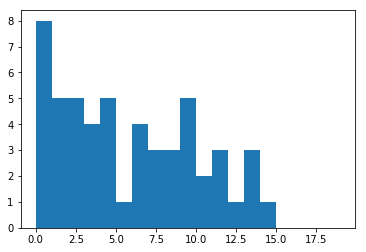

In [13]:
## Master(어린 남자아이) 나이
plt.hist(df[df["Title"]=="Master"]["Age"], bins=range(0, 20, 1))

In [14]:
## 중앙값으로 채우기
df["Age2"] = df[df["Title"]=="Master"]["Age"].fillna(df[df["Title"]=="Master"]["Age"].median())

In [15]:
## 일관된 형식을 위해 Ticket2 생성
df["Ticket2"] = df["Ticket"].apply(lambda x: x.upper().translate(str.maketrans({"/": None, ".": None})).strip())
df["Ticket2"] = df["Ticket2"].apply(lambda x: "LINE/" if "LINE" in x else "".join(x.split(" ")[:-1]) + "/" + x.split(" ")[-1])

In [16]:
## Spouse
sp = {k: v["PassengerId"].tolist()
      for k, v in df[(df["SibSp"] > 0)
                     & (df["Title"].apply(lambda x: x in ["Mr", "Mrs"]))
                     & (df["Name2"].apply(lambda x: " Jr" not in x))].groupby(["LName", "FName", "Ticket2"])
      if len(v["PassengerId"]) > 1}

In [17]:
del sp[('Goodwin', 'Charles', 'CA/2144')]

In [18]:
## [Mr, Mrs] 순서로 정렬
sp2 = {(k if df[df["PassengerId"]==v[0]]["Sex_female"].values[0] == 0 else k):
       (v if df[df["PassengerId"]==v[0]]["Sex_female"].values[0] == 0 else list(reversed(v)))
       for k, v in sp.items()}

In [19]:
## 부부 나이 차이
sp3 = {k: df[df["PassengerId"]==v[0]]["Age"].values[0] - df[df["PassengerId"]==v[1]]["Age"].values[0]
       for k, v in sp2.items()}

(array([ 1.,  0.,  1.,  0.,  0.,  0.,  3.,  7., 37., 17., 12.,  3.,  1.]),
 array([-40, -35, -30, -25, -20, -15, -10,  -5,   0,   5,  10,  15,  20,
         25]),
 <a list of 13 Patch objects>)

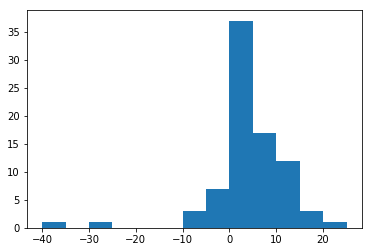

In [20]:
plt.hist(sp3.values(), bins=range(-40, 30, 5))

In [21]:
## 중앙값으로 채우기